In [4]:
!pip install mplfinance

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import ipywidgets as widgets
from IPython.display import display
import datetime

1. Enter a stock ticker symbol
2. Select start and end dates
3. Adjust the Keltner Channel parameters if desired
4. Click 'Compute' to generate the Keltner Channel
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Detected MultiIndex columns - flattening...
Final columns: Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
Plotting...


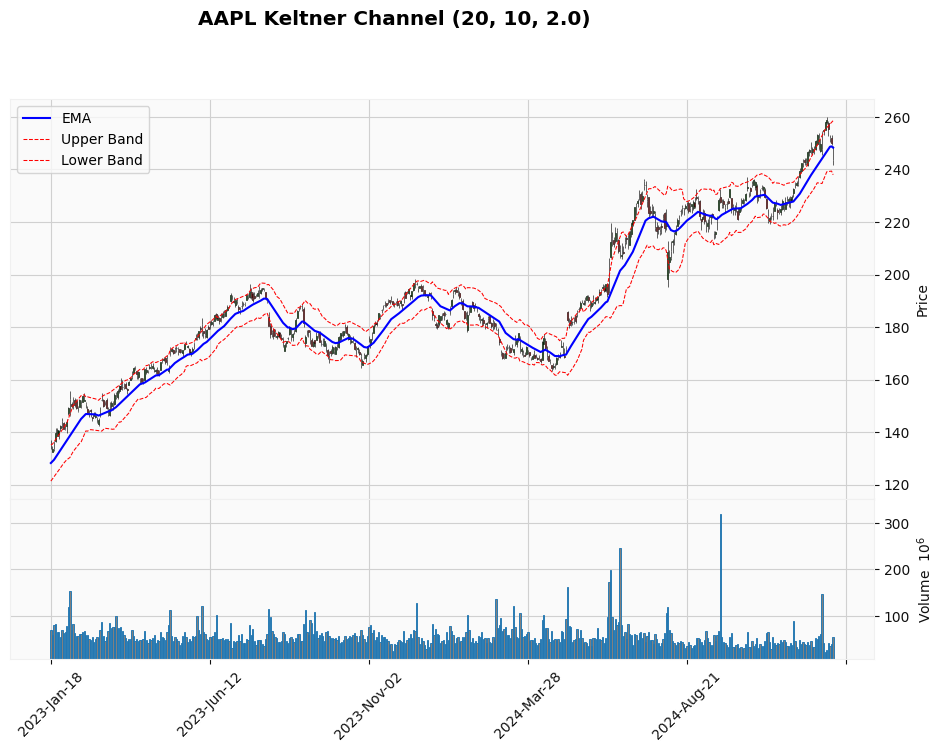

Plot successful!


[*********************100%***********************]  1 of 1 completed


Detected MultiIndex columns - flattening...
Final columns: Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
Plotting...


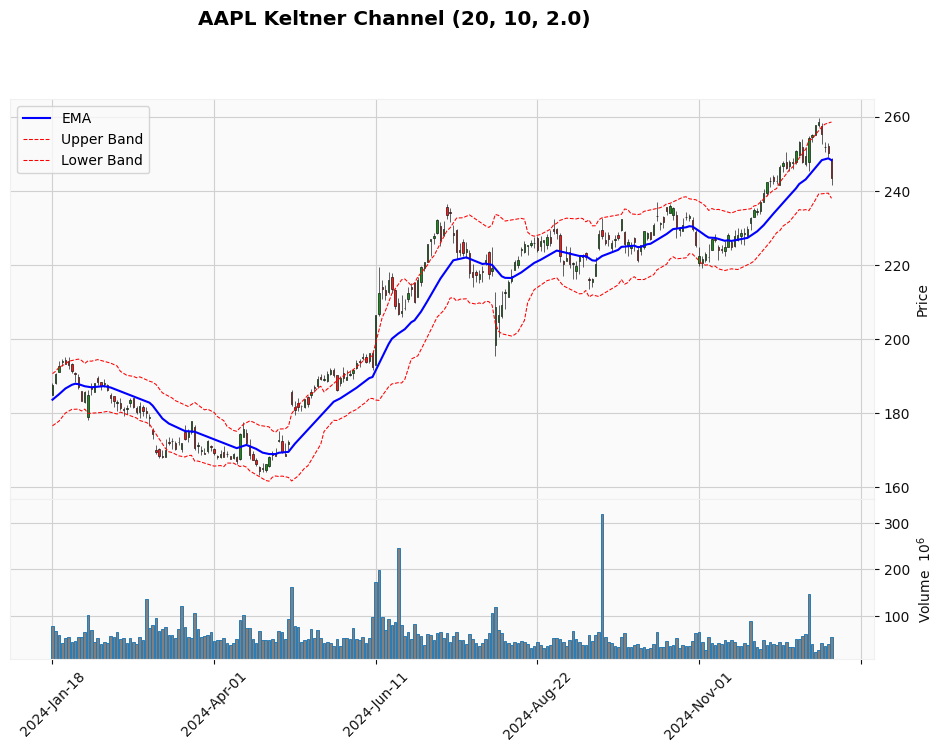

Plot successful!


[*********************100%***********************]  1 of 1 completed


Detected MultiIndex columns - flattening...
Final columns: Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
Plotting...


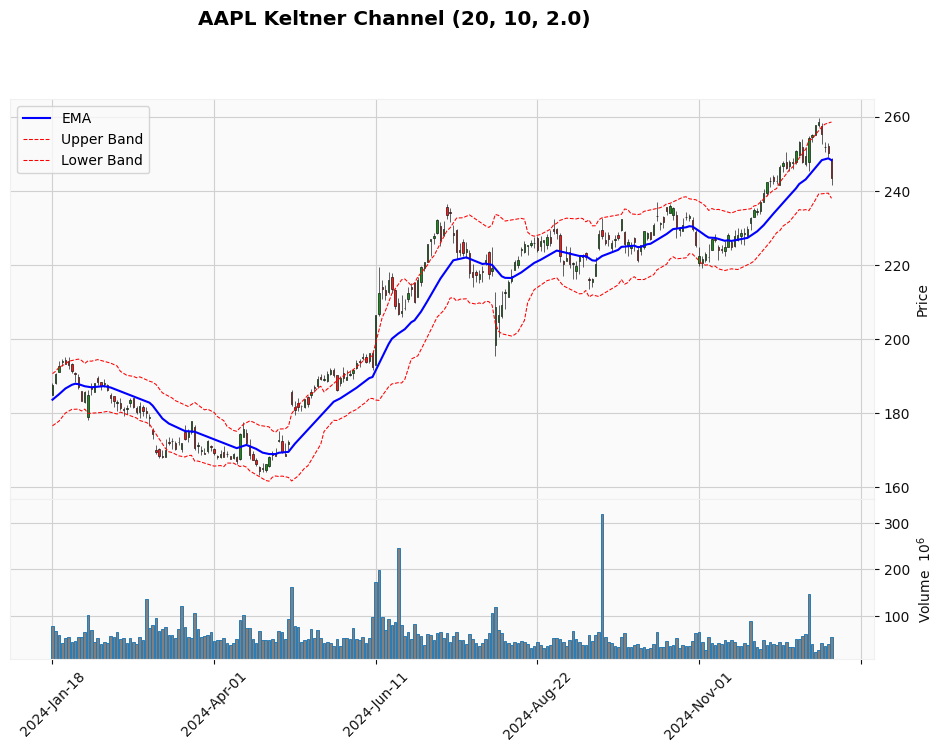

Plot successful!


[*********************100%***********************]  1 of 1 completed


Detected MultiIndex columns - flattening...
Final columns: Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
Plotting...


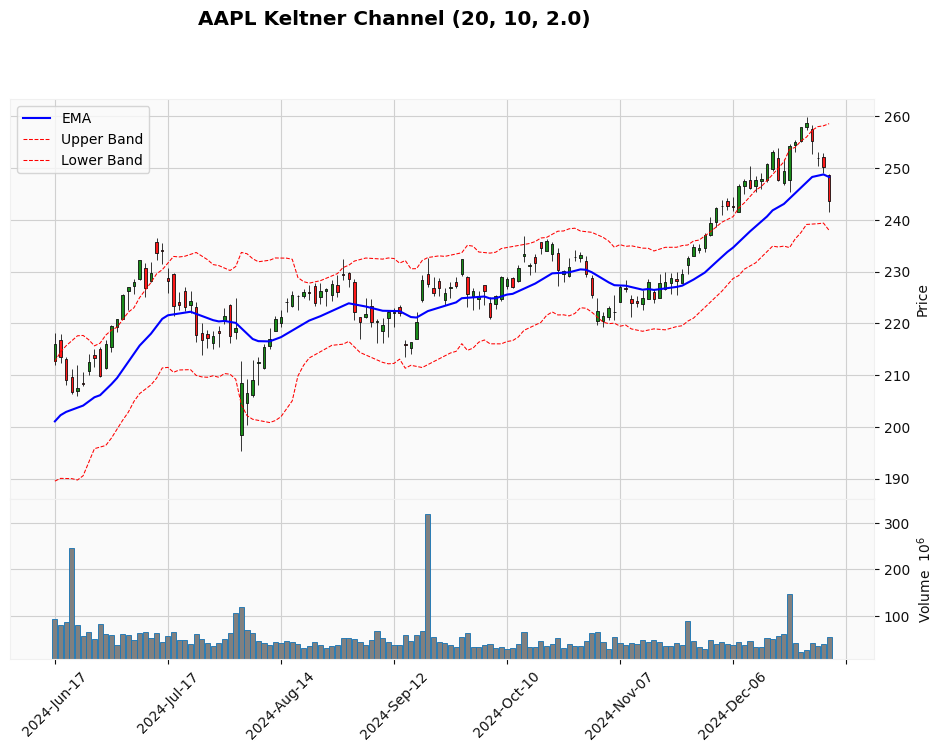

Plot successful!


In [6]:
def plot_keltner_channel(stock_symbol, start_date, end_date, ema_period=20, atr_period=10, multiplier=2):

    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

    if stock_data.empty:
        print(f"No data available for {stock_symbol} between {start_date} and {end_date}.")
        return

    if isinstance(stock_data.columns, pd.MultiIndex):
        print("Detected MultiIndex columns - flattening...")
        if len(stock_data.columns.levels[1]) == 1:
            ticker = stock_data.columns.levels[1][0]
            data = pd.DataFrame()
            for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
                if (col, ticker) in stock_data.columns:
                    data[col] = stock_data[(col, ticker)]
            stock_data = data
        else:
            print("Multiple tickers detected, using the first one")
            ticker = stock_data.columns.levels[1][0]
            data = pd.DataFrame()
            for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
                if (col, ticker) in stock_data.columns:
                    data[col] = stock_data[(col, ticker)]
            stock_data = data

    print("Final columns:", stock_data.columns)

    stock_data['EMA'] = stock_data['Close'].ewm(span=ema_period, adjust=False).mean()

    stock_data['TR'] = np.maximum(
        np.maximum(
            stock_data['High'] - stock_data['Low'],
            np.abs(stock_data['High'] - stock_data['Close'].shift(1))
        ),
        np.abs(stock_data['Low'] - stock_data['Close'].shift(1))
    )
    stock_data['ATR'] = stock_data['TR'].rolling(window=atr_period).mean()

    stock_data['Upper_Band'] = stock_data['EMA'] + (multiplier * stock_data['ATR'])
    stock_data['Lower_Band'] = stock_data['EMA'] - (multiplier * stock_data['ATR'])

    stock_data = stock_data.dropna()

    if len(stock_data) < 2:
        print("Not enough data points after calculations. Try a longer date range.")
        return

    try:
        apds = [
            mpf.make_addplot(stock_data['EMA'], color='blue', width=1.5, label='EMA'),
            mpf.make_addplot(stock_data['Upper_Band'], color='red', linestyle='--', width=0.75, label='Upper Band'),
            mpf.make_addplot(stock_data['Lower_Band'], color='red', linestyle='--', width=0.75, label='Lower Band')
        ]

        mc = mpf.make_marketcolors(up='g', down='r', edge='black', wick='black', volume='gray')
        s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)

        print("Plotting...")
        mpf.plot(
            stock_data,
            type='candle',
            addplot=apds,
            style=s,
            title=f'{stock_symbol} Keltner Channel ({ema_period}, {atr_period}, {multiplier})',
            volume=True,
            figsize=(12, 8)
        )
        print("Plot successful!")

    except Exception as e:
        print(f"Error during plotting: {e}")
        print("First few rows of the data:")
        print(stock_data.head())

ticker_input = widgets.Text(description="Ticker:")
start_date_input = widgets.DatePicker(description="Start Date")
end_date_input = widgets.DatePicker(description="End Date")
ema_slider = widgets.IntSlider(value=20, min=5, max=50, step=1, description="EMA Period:")
atr_slider = widgets.IntSlider(value=10, min=5, max=30, step=1, description="ATR Period:")
multiplier_slider = widgets.FloatSlider(value=2.0, min=0.5, max=5.0, step=0.1, description="Multiplier:")
compute_button = widgets.Button(description="Compute")

end_date_input.value = datetime.datetime.now()
start_date_input.value = end_date_input.value - datetime.timedelta(days=180)

def on_compute_button_clicked(b):
    if start_date_input.value is None or end_date_input.value is None:
        print("Please select valid start and end dates.")
        return

    start_date_str = start_date_input.value.strftime('%Y-%m-%d')
    end_date_str = end_date_input.value.strftime('%Y-%m-%d')

    plot_keltner_channel(
        ticker_input.value,
        start_date_str,
        end_date_str,
        ema_slider.value,
        atr_slider.value,
        multiplier_slider.value
    )

compute_button.on_click(on_compute_button_clicked)

display(widgets.VBox([
    ticker_input,
    widgets.HBox([start_date_input]),
    widgets.VBox([end_date_input, ema_slider, atr_slider, multiplier_slider]),
    compute_button
]))

print("1. Enter a stock ticker symbol")
print("2. Select start and end dates")
print("3. Adjust the Keltner Channel parameters if desired")
print("4. Click 'Compute' to generate the Keltner Channel")